In [1]:
import gym
from gym import spaces
import os
import time
import datetime

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import Model
from tensorflow.keras import initializers
from tensorflow.keras import optimizers
from tensorflow.keras import backend

import numpy as np
import matplotlib.pyplot as plt

from distutils.log import error

from tensorflow.python.ops.numpy_ops import np_config
# np_config.enable_numpy_behavior()
# tf.config.run_functions_eagerly(True)

# Networks
from networks import *

# Helpers
from helpers import *

# Main Coop_MADDPG class
from MADDPG import *

# Rando and test functions
from rando_test import *

In [2]:
def run(env, continuous, total_trials=1, total_episodes=100, 
            disc_actions_num=2, seed=1453,
            buffer_capacity=50000, batch_size=64, num_agents=4, learn_step=25,
            std_dev=0.3, epsilon=0.2, actor_lr=0.002, critic_lr=0.003, clip=1,
            gamma=0.99, tau=0.005, adam_eps=1e-07, amsgrad=False, theta=0.15,
            gamma_func=fixed, tau_func=fixed, critic_lr_func=fixed, actor_lr_func=fixed, std_dev_func=fixed, epsilon_func=fixed,
            reward_mod=False, start_steps=0, loss_func=losses.MeanAbsoluteError(),
            mean_number=20, solved=999,
            render=False, weights_directory='Weights/', plots_directory='Graphs/', 
            output=True, total_time=True, use_gpu=True, return_data=False):
    
    start_time = time.time()
    
    # _ = env.seed(seed)
    rng = np.random.default_rng(seed)

    num_states = env.observation_space[0].shape[0]
    if continuous:
        num_actions = env.action_space.shape[0]
    else:
        num_actions = 1
    
    if not use_gpu:
        os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

    # Normalize action space according to https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
    # env.action_space = spaces.Box(low=-1, high=1, shape=(num_actions,), dtype='float32')
    
    ep_reward_list = []
    avg_reward_list = []
    true_reward_list = []
    true_avg_reward_list = []
    
    for trial in range(total_trials):
        step = 0

        # Add sublists for each trial
        avg_reward_list.append([])
        ep_reward_list.append([])
        true_reward_list.append([])
        true_avg_reward_list.append([])
        
        agent = Coop_MADDPG(num_states, num_actions, num_agents, continuous,
            buffer_capacity, batch_size, std_dev, epsilon,
            actor_lr, critic_lr, gamma, tau, clip,
            adam_eps, amsgrad, theta, disc_actions_num, loss_func)

        for ep in range(total_episodes):
            before = time.time()
            
            agent.gamma = gamma_func(agent.gamma, ep)
            agent.tau = tau_func(agent.tau, ep)
            agent.critic_lr = critic_lr_func(agent.critic_lr, ep)
            agent.actor_lr = actor_lr_func(agent.actor_lr, ep)
            agent.std_dev = std_dev_func(agent.std_dev, ep)
            agent.epsilon = epsilon_func(agent.epsilon, ep)

            prev_state = env.reset()
            episodic_reward = np.zeros(num_agents)
            true_reward = np.zeros(num_agents)

            while True:
                if render:
                    env.render()
                
                tf_prev_state = tf.convert_to_tensor(prev_state)

                if step >= start_steps:
                    action = agent.policy(state=tf_prev_state, noise_object=agent.ou_noise, rng=rng)
                else:
                    action = two_mini_random(num_agents)
                
                step += 1

                # TESTING **********************************
                # time.sleep(0.5)
                # print(action)
                
                if continuous:
                    # try:
                    #     len(action)
                    # except:
                    #     action = [action]
                    # state, reward, done, info = env.step(action)
                    raise ValueError('not implemented continuous')
                else:
                    # take the argmax to get correct action format [0, 1] instead of [(0.7,0.3), (0.2,0.8)]
                    state, reward, done, info = env.step(np.argmax(action, axis=1).tolist())
                
                true_reward = true_reward.__add__(reward)
                
                terminal_state = np.array(np.invert(done),dtype=np.float32)

                # Reward modification
                if reward_mod:
                    if all(done):
                        reward_addition = [10]*num_agents
                        reward = [reward[i] + reward_addition[i] for i in range(len(reward))]
                
                agent.record((prev_state, action, reward, state, terminal_state))

                if step % learn_step == 0:
                    agent.learn()
                    update_target(agent.target_actor.variables, agent.actor_model.variables, agent.tau)
                    update_target(agent.target_critic.variables, agent.critic_model.variables, agent.tau)

                episodic_reward = episodic_reward.__add__(reward)

                prev_state = state
                
                if all(done):
                    break

            list_reward = episodic_reward
            episodic_reward = np.sum(episodic_reward)
            true_reward = np.sum(true_reward)

            ep_reward_list[trial].append(episodic_reward)
            avg_reward = np.mean(ep_reward_list[trial][-mean_number:])
            avg_reward_list[trial].append(avg_reward)
            true_reward_list[trial].append(true_reward)
            true_avg_reward = np.mean(true_reward_list[trial][-mean_number:])
            true_avg_reward_list[trial].append(true_avg_reward)
            
            if output:
                if reward_mod:
                    print("Ep {} * AvgReward {:.2f} * true AvgReward {:.2f} * Reward {:.2f} * True Reward {:.2f} * time {:.2f} * step {}"
                    .format(ep, avg_reward, true_avg_reward, episodic_reward, true_reward, (time.time() - before), step))
                else:
                    print("Ep {} * AvgReward {:.2f} * ListRew {} * Reward {:.2f} * time {:.2f} * step {}"
                    .format(ep, avg_reward, str(list_reward), episodic_reward, (time.time() - before), step))
            
            # Stop if avg is above 'solved'
            if true_avg_reward >= solved:
                break

        # Save weights
        save_weights(agent, env, weights_directory, trial)
    
    # Plotting graph
    now = datetime.datetime.now()
    timestamp = "{}.{}.{}.{}.{}.{}".format(now.year, now.month, now.day, now.hour, now.minute, now.second)
    save_name = "{}_{}_{}".format(env.spec.id, agent.continuous, timestamp)
    for idx, p in enumerate(true_avg_reward_list):
        plt.plot(p, label=str(idx))
    plt.xlabel("Episode")
    plt.ylabel("True Avg. Epsiodic Reward (" + str(mean_number) + ")")
    plt.legend()
    try:
        plt.savefig(plots_directory + save_name + '.png')
    except:
        print('Graph save fail')
    plt.show()
    
    print('total time:', time.time() - start_time, 's')
    
    if return_data:
        return agent, ep_reward_list, true_reward_list

---
# Runs and tests
---

In [3]:
env = gym.make('ma_gym:TrafficJunction4-v0')
env.reset()
print(env.action_space)
# print(env.observation_space)
obs, rew, done, _ = env.step(np.random.randint(0,2,(4)).tolist())
print(obs[0].shape)
print(rew)
print(done)
env.reset()
env._max_steps = 80 # reduce from 100 for faster environments

[Discrete(2), Discrete(2), Discrete(2), Discrete(2)]
(81,)
[-0.01, -0.01, -0.01, -0.01]
[False, False, False, False]


c:\ProgramData\Miniconda3\lib\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


64, 324 (64, 324)
256, 81 (256, 81)
64, 324 (64, 324)
64, 8 (64, 8)
target_actions, should be (64,8) and is (64, 8)
64, 1 (64, 1)
64, 1 (64, 1)
64, 324 (64, 324)
256, 81 (256, 81)
64, 324 (64, 324)
64, 8 (64, 8)
target_actions, should be (64,8) and is (64, 8)
64, 1 (64, 1)
64, 1 (64, 1)
Ep 0 * AvgReward -66.36 * ListRew [-32.4   -0.78 -32.4   -0.78] * Reward -66.36 * time 3.60 * step 80
Ep 1 * AvgReward -72.06 * ListRew [-32.4  -26.3  -12.75  -6.3 ] * Reward -77.75 * time 1.10 * step 160
Ep 2 * AvgReward -59.75 * ListRew [-32.4   -0.91  -0.78  -1.05] * Reward -35.14 * time 1.06 * step 240
Ep 3 * AvgReward -62.59 * ListRew [-32.4  -32.4   -1.05  -5.28] * Reward -71.13 * time 1.08 * step 320
Ep 4 * AvgReward -63.46 * ListRew [-32.4  -32.4   -0.78  -1.36] * Reward -66.94 * time 1.02 * step 400
Ep 5 * AvgReward -64.11 * ListRew [-32.4  -32.4   -1.2   -1.36] * Reward -67.36 * time 1.06 * step 480
Ep 6 * AvgReward -65.92 * ListRew [-32.4  -32.4  -11.2   -0.78] * Reward -76.78 * time 1.15 * s

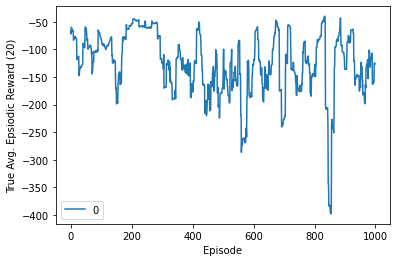

total time: 1379.2688405513763 s


In [4]:
ag, rl, trl = run(env, False, total_trials=1, total_episodes=3000, 
        disc_actions_num=2, seed=1453,
        buffer_capacity=100000, batch_size=128, num_agents=4, learn_step=2,
        std_dev=0.3, epsilon=0.1, actor_lr=0.0005, critic_lr=0.001, clip=2,
        gamma=0.99, tau=0.001, adam_eps=1e-07, amsgrad=False, theta=0.15,
        gamma_func=fixed, tau_func=fixed, critic_lr_func=fixed, actor_lr_func=fixed, std_dev_func=fixed, epsilon_func=fixed,
        reward_mod=False, start_steps=1000, loss_func=losses.MeanSquaredError(),
        mean_number=40, solved=-6,
        render=False, weights_directory='Weights/', plots_directory='Graphs/', 
        output=True, total_time=True, use_gpu=True, return_data=True)

In [5]:
a = get_actor(81, 1, False, 2)
b = get_critic(81, 4, 1, False, 2)
obs = np.array(obs)
state = np.stack((obs, obs)*32)
print('state shape',state.shape)
rewo = np.expand_dims(np.stack((rew, rew)*32),-1)
print('rewo shape', rewo.shape)
dd = np.array(np.invert(done),dtype=np.float32)
ddd = np.expand_dims(np.stack((dd,dd)*32),-1)
print('done shape', ddd.shape)

state_first_flat = state.reshape(-1, state.shape[-1])
print(state_first_flat.shape)
state_last_flat = state.reshape(state.shape[0], -1)
print(state_last_flat.shape)

state shape (64, 4, 81)
rewo shape (64, 4, 1)
done shape (64, 4, 1)
(256, 81)
(64, 324)


In [ ]:
# rando(env, continuous=False, total_episodes=10, render=True, timing=False, testing=True)

In [ ]:
# ca. best case reward
-np.sum(np.arange(0, 0.01*14, 0.01)) * 4

-4.2

In [11]:
rel = rando(env, total_episodes=1000, render=False, timing=False, testing=False)

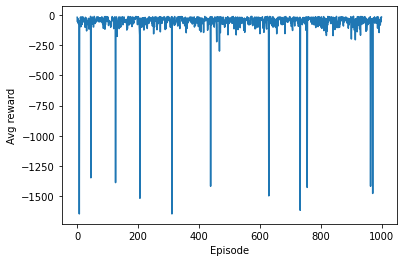

In [12]:
plt.plot(rel)
plt.xlabel("Episode")
plt.ylabel("Avg reward")
plt.show()

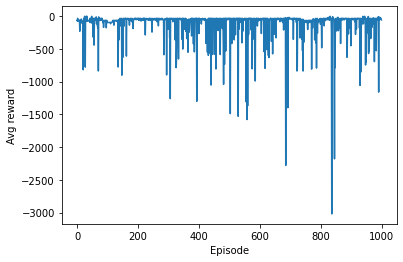

In [9]:
plt.plot(rl[0])
plt.xlabel("Episode")
plt.ylabel("Avg reward")
plt.show()

In [15]:
print(np.mean(rl[0]))
print(np.mean(rel))


-125.94582999999999
-62.78546


In [ ]:
a = ag.done_buffer.tolist()
with open("debug/done_buffer.txt", "w") as file1:
    for l in a:
        file1.writelines(str(l)+'\n')

In [ ]:
a = ag.action_buffer.tolist()
with open("debug/action_buffer.txt", "w") as file1:
    for l in a:
        file1.writelines(str(l)+'\n')

In [ ]:
a = ag.state_buffer.tolist()
with open("debug/state_buffer.txt", "w") as file1:
    for l in a:
        file1.writelines(str(l)+'\n')

In [ ]:
a = ag.next_state_buffer.tolist()
with open("debug/next_state_buffer.txt", "w") as file1:
    for l in a:
        file1.writelines(str(l)+'\n')

In [ ]:
a = ag.reward_buffer.tolist()
with open("debug/reward_buffer.txt", "w") as file1:
    for l in a:
        file1.writelines(str(l)+'\n')

In [ ]:
# make_world()
# reset_world()
# reward()
# observation()

In [ ]:
# env = gym.make('simple.py')
# env.reset()

In [ ]:
# from pettingzoo.butterfly import pistonball_v6
# parallel_env = pistonball_v6.parallel_env()
# observations = parallel_env.reset()
# env = pistonball_v6.parallel_env()
# parallel_api_test(env, num_cycles=1000)